In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os

In [2]:
df = pd.read_csv('kognoz2.csv')
df.head(5)

,Unnamed: 0,Unnamed: 0.1,title,link,description,pubDate,articleid,website,issue,type,showcase
0,0,0,No Duty on Chinese Imports for Public Solar Po...,http://myimpact.in/index.php?page=Clipj&id=00e...,New Delhi Chinese imports for public solar po...,2020-07-01,003bd7b1-bb3f-11ea-87c0-70f3955ff93a,The Economic Times - Delhi,Power Industry News,print,NO
1,1,1,Solar Tariffs Fall to Record Low of Rs 2.36/Unit,http://myimpact.in/index.php?page=Clipj&id=fe5...,Bengaluru: Solar tariffs fell to a record low...,2020-07-01,0486da8f-bb41-11ea-b40c-0068ebdc2fd0,The Economic Times - Mumbai,General Industry news,print,NO
2,2,2,Corning appoints new MD for India,http://myimpact.in/index.php?page=Clipj&id=234...,Corning Incorporated has announced that Sudhi...,2020-07-01,3497c933-bb95-11ea-9c46-,BioSpectrum - National,General Industry news,print,NO
3,3,3,L&T Makes Key Component for Advanced Nuclear R...,http://myimpact.in/index.php?page=Clipj&id=490...,MUMBAI Larsen & Toubro has completed the manu...,2020-07-01,3aa7ae60-bb3f-11ea-87c0-70f3955ff93a,The Economic Times - Delhi,General Industry news,print,NO
4,4,4,Two percent discount on lump sum payment of el...,http://myimpact.in/index.php?page=Clipj&id=566...,NaN,2020-07-01,41b5248a-bb4f-11ea-a37a-0068ebdd9697,Saamna - Mumbai,Power Industry News,print,NO


In [3]:
df['issue'].value_counts()

0                        149
Power Industry News      121
General Industry news    115
Electric Vehicles         70
Niti Aayog                45
Name: issue, dtype: int64

In [4]:
df['issue'] = df['issue'].replace(["Customers News"],"0")
df['issue'] = df['issue'].replace(["Power Industry News"],"1")
df['issue'] = df['issue'].replace(["General Industry news"],"2")
df['issue'] = df['issue'].replace(["Electric Vehicles"],"3")
df['issue'] = df['issue'].replace(["Niti Aayog  "],"4")

In [5]:
final = df

In [6]:
sent_0 = final['description'].values[245]
print(sent_0)

 Yost cited a 2019 study that GM's Lordstown closure resulted in the loss of nearly 8,000 jobs and more than $8 billion in local economic activity, while the local school district had relied on the plant for 10% of its budget.<p> GM said Tuesday it "has demonstrated its commitment to Ohio through our investments of more than $3.3 billion in Ohio since 2009 ... We look forward to continuing our dialogue with the state."</p><p> As recently as 2016, GM employed 4,500 people at Lordstown and cut the final 1,500 jobs when production of the slow-selling Chevrolet Cruze ended.</p><p> GM sold the plant to an electric vehicle startup Lordstown Motors that hopes to begin production next year with a few hundred workers.</p><p> GM and LG Chem are investing $2.2 billion to build a battery cell manufacturing plant in Lordstown that will create 1,100 jobs.</p><p> Ohio Governor Mike DeWine told reporters last week the state does not "necessarily have to get that cash back but what we do want to see is

In [7]:
final['description']=final['description'].apply(str)

In [8]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [10]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['description'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 200.60it/s]


In [11]:
preprocessed_reviews[245]

'yost cited study gm lordstown closure resulted loss nearly jobs billion local economic activity local school district relied plant budget gm said tuesday demonstrated commitment ohio investments billion ohio since look forward continuing dialogue state recently gm employed people lordstown cut final jobs production slow selling chevrolet cruze ended gm sold plant electric vehicle startup lordstown motors hopes begin production next year hundred workers gm lg chem investing billion build battery cell manufacturing plant lordstown create jobs ohio governor mike dewine told reporters last week state not necessarily get cash back want see things promote jobs ohio not actively pursuing clawback also read u appeals court stays order requiring gm fca meet resolve gm lawsuit'

In [12]:
final['Cleaned_Text'] = preprocessed_reviews

In [13]:
x = final['Cleaned_Text']
x.size

500

In [14]:
y = final['issue']
y.size

500

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

# BOW

In [16]:
count_vect = CountVectorizer()
bow_X_train = count_vect.fit_transform(x_train)
bow_X_test = count_vect.transform(x_test)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

alphas = [0.01,0.1,1,10,100]
clf = MultinomialNB()
param_grid = { 'alpha':alphas}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = -1)
grid.fit(bow_X_train, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
t_acc1 = grid.best_score_*100
a = grid.best_params_
optimal_a1 = a.get('alpha')

D:\window_soft_install_here\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best alpha =  {'alpha': 0.01}
Accuracy on train data =  76.85714285714286


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


clf = MultinomialNB(alpha = optimal_a1)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)



acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred, average = None) * 100
rec1 = recall_score(y_test, pred, average = None) * 100
f11 = f1_score(y_test, pred, average = None) * 100

print("accuracy = ",acc1)
print("precision =",pre1)
print("recall = ", rec1)
print("F1-Score = ",f11)

accuracy =  80.66666666666666
precision = [ 78.57142857  92.          68.18181818  94.11764706 100.        ]
recall =  [93.61702128 60.52631579 81.08108108 88.88888889 80.        ]
F1-Score =  [85.4368932  73.01587302 74.07407407 91.42857143 88.88888889]


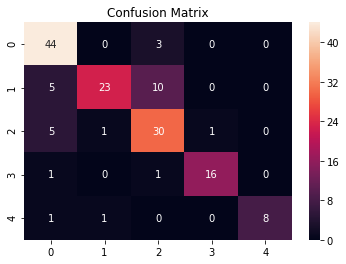

In [19]:

import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

# TF-IDF

In [22]:
tf_idf = TfidfVectorizer()
tf_X_train = tf_idf.fit_transform(x_train)
tf_X_test = tf_idf.transform(x_test)

In [23]:

alphas = [0.01,0.1,1,10,100]
clf = MultinomialNB()
param_grid = { 'alpha':alphas}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = -1)
grid.fit(tf_X_train, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
t_acc2 = grid.best_score_*100
a = grid.best_params_
optimal_a2 = a.get('alpha')

D:\window_soft_install_here\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best alpha =  {'alpha': 0.1}
Accuracy on train data =  77.42857142857143


In [24]:
clf = MultinomialNB(alpha = optimal_a2)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred, average = None) * 100
rec2 = recall_score(y_test, pred, average = None) * 100
f12 = f1_score(y_test, pred, average = None) * 100

print("accuracy = ",acc2)
print("precision =",pre2)
print("recall = ", rec2)
print("F1-Score = ",f12)

accuracy =  82.0
precision = [83.33333333 92.         69.04761905 89.47368421 90.        ]
recall =  [95.74468085 60.52631579 78.37837838 94.44444444 90.        ]
F1-Score =  [89.10891089 73.01587302 73.41772152 91.89189189 90.        ]


In [27]:
from prettytable import PrettyTable

x = PrettyTable()

model_1 = 'NB on BoW'
model_2 = 'NB on Tf-Idf'
x.field_names = ["Model","Test_Acc", "f1"]



acc1 = np.around(acc1, decimals = 2)
f11 = np.around(f11, decimals = 2)
f12 = np.around(f12, decimals = 2)

acc2 = np.around(acc2, decimals = 2)

x.add_row([model_1,acc1,f11 ])
x.add_row([model_2,acc2,f12 ])

print(x)

+--------------+----------+---------------------------------+
|    Model     | Test_Acc |                f1               |
+--------------+----------+---------------------------------+
|  NB on BoW   |  80.67   | [85.44 73.02 74.07 91.43 88.89] |
| NB on Tf-Idf |   82.0   | [89.11 73.02 73.42 91.89 90.  ] |
+--------------+----------+---------------------------------+
